# **Starch detection from confocal stomatal images - training**

Autors: Santelia Lab at ETH Zurich

Contact: hongyuan.zhang@usys.ethz.ch

## Reference
[MMDetection](https://github.com/open-mmlab/mmdetection)
<br><br>
[MMSegmentation](https://github.com/open-mmlab/mmsegmentation)
<br><br>
[Instance segmentation on COCO benchmark](https://paperswithcode.com/sota/instance-segmentation-on-coco)
<br><br>
[Semantic segmentation on ADE20K benchmark](https://paperswithcode.com/sota/semantic-segmentation-on-ade20k)
<br><br>
[Image classification on ImageNet benchmark](https://paperswithcode.com/sota/image-classification-on-imagenet)
<br><br>
[Masked-attention mask transformer for universal image segmentation (Mask2Former) by Cheng, Bowen, et al., 2022](https://arxiv.org/abs/2112.01527)
<br><br>

### install mmdetection and mmsegmentation

In [1]:
%cd ..

c:\Users\zhongyua\OneDrive\Academics\2023 ETH\Projects\PhD thesis\StomataPy


In [ ]:
import os
from stomatapy.models.openmmlab import OpenMMlab
from stomatapy.core.core import get_paths


root = 'Datasets/Koheler2023/stomatal density'

folder_dirs = [os.path.join(root, folder) for folder in os.listdir(root)]

for folder_dir in folder_dirs:
    subfolder_dirs = [os.path.join(folder_dir, subfolder) for subfolder in os.listdir(folder_dir)]
    for subfolder_dir in subfolder_dirs:
        
        image_paths = get_paths(subfolder_dir, '.png') + get_paths(subfolder_dir, '.tif') + get_paths(subfolder_dir, '.jpg')

        test = OpenMMlab(
                detector_config_path='Checkpoints/Swin-S_Mask2Former_Koheler2023_0805/Swin-s_mask2former_config.py',
                detector_weight_path='Checkpoints/Swin-S_Mask2Former_Koheler2023_0805/best_coco_segm_mAP_epoch_149.pth',
                detector_threshold=0.8,
                segmentor_config_path='Checkpoints/Rein_Dinov2_Mask2Former_gmax/rein_dinov2_mask2former_config.py',
                segmentor_weight_path='Checkpoints/Rein_Dinov2_Mask2Former_gmax/dinov2_segmentor.pth',
                use_sahi=True
            ).detect_stomata(image_paths, if_resize_image=True, if_visualize=False, if_auto_label=True)

In [3]:
import os
import json
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd  # for Excel sheet
from matplotlib import pyplot as plt
from stomatapy.core.core import get_paths, imread_rgb
from stomatapy.core.isat import UtilsISAT
from stomatapy.utils.stoma_dimension import GetDiameter

def if_seg_on_edges(seg_mask: np.ndarray, edge_width: int = 3) -> bool:
    """Check if the segmentation mask has been cut off by any edges"""
    top_edge = seg_mask[:edge_width, :]  # pixels on the top edge
    bottom_edge = seg_mask[-edge_width:, :]  # bottom edge
    left_edge = seg_mask[:, :edge_width]  # left edge
    right_edge = seg_mask[:, -edge_width:]  # right edge
    edges = [top_edge, bottom_edge, left_edge, right_edge]  # all four edges
    return any(np.any(edge) for edge in edges)

scale = 2.9  # scale (pixels per micron)
batch_results = pd.DataFrame()

root = 'Datasets/Koheler2023/stomatal density'
folder_dirs = [os.path.join(root, folder) for folder in os.listdir(root)]

for folder_dir in tqdm(folder_dirs, total=len(folder_dirs)):
    subfolder_dirs = [os.path.join(folder_dir, subfolder) for subfolder in os.listdir(folder_dir)]
    for subfolder_dir in subfolder_dirs: 
        json_paths = get_paths(subfolder_dir, 'json')
        for json_path in json_paths:
            with open(json_path, 'r', encoding='utf-8') as file:
                data = json.load(file)  # load the json file
            image_name = data['info']['name']
            image_path = os.path.join(subfolder_dir, image_name)  # get the image path
            image = imread_rgb(image_path)  # load the image
            image_dimension = (data['info']['height'], data['info']['width'])  # get the image dimension
            for idx, obj in enumerate(data['objects']):
                overlay_color = np.array([0, 0, 255])
                mask = obj['segmentation']  # get the ISAT format segmentation mask
                mask_bool = UtilsISAT.segmentation2mask(mask, image_dimension)  # convert the ISAT mask to a bool mask
                if not if_seg_on_edges(mask_bool):
                    mask_area = np.sum(mask_bool) * (1 / scale) ** 2 # get the mask area
                    bbox = obj['bbox']  # get the object bbox
                    padding = max((bbox[2] - bbox[0]), (bbox[3] - bbox[1])) // 4  # calculate the padding value of the bbox as max 25% of either dimension
                    mask_filled = np.uint8(np.stack([mask_bool, mask_bool, mask_bool], axis=-1) * 255)  # fill in the bool mask with RGB white color for dimension
                    cropped_mask = UtilsISAT.crop_image_with_padding(mask_filled, bbox, padding, allow_negative_crop=True)  # crop the mask to be focused
                    dimension = GetDiameter(cropped_mask, shrink_ratio=0.8, line_thickness=1).pca()  # get the lenghth and the width of the object
                    length, width = dimension['length'] * (1 / scale), dimension['width'] * (1 / scale)  # convert the length and the width to microns
                    length_points, width_points = dimension['length_points'], dimension['width_points']
                    x_min_padded, y_min_padded = bbox[0] - padding, bbox[1] - padding
                    original_length_points = [(int(x + x_min_padded), int(y + y_min_padded)) for x, y in length_points]
                    original_width_points = [(int(x + x_min_padded), int(y + y_min_padded)) for x, y in width_points]
                    overlay_color = np.array([255, 0, 0])
                    cv2.line(image, original_length_points[0], original_length_points[1], (0, 255, 0), 2)  # draw the length
                    cv2.line(image, original_width_points[0], original_width_points[1], (0, 0, 255), 2)  # draw the width
                    result = {
                        'folder': os.path.dirname(folder_dir),
                        'subfolder': os.path.dirname(subfolder_dir),
                        'image_name': image_name,
                        'object_idx': idx,
                        'object_category': 'stomatal complex',
                        'area  (\u03BCm\N{SUPERSCRIPT TWO})': mask_area,
                        'length (\u03BCm)': length,
                        'width (\u03BCm)': width,
                        'angle (°)': dimension['angle'],
                    }
                    result = pd.DataFrame(data=[result])  # collect result in a pd dataframe for exporting to an Excel sheet
                    batch_results = pd.concat([batch_results, result], axis=0)  # concatenate all results
                image[mask_bool] = image[mask_bool] * 0.5 + overlay_color * 0.5  # create starch overlay on the original image
            cv2.imwrite(os.path.join(subfolder_dir, f'{os.path.splitext(image_name)[0]}_prediction.png'), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # export the image
batch_results.to_excel(os.path.join(root, 'results.xlsx'), index=False)  # export the summarized results to Excel    

100%|██████████| 140/140 [16:29<00:00,  7.07s/it]


### check GPU availability

In [1]:
%cd ..

c:\Users\zhongyua\OneDrive\Academics\2023 ETH\Projects\PhD thesis\StomataPy


08/26/2024 13:55:17 - WARNING - xformers -   A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


Loads checkpoint by local backend from path: Checkpoints/Rein_Dinov2_Mask2Former_2906_SanteliaPeels/dinov2_segmentor.pth
Loads checkpoint by local backend from path: Checkpoints/Swin-S_Mask2Former_2906_SanteliaPeels/best_coco_segm_mAP_epoch_220.pth
08/26 13:55:22 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


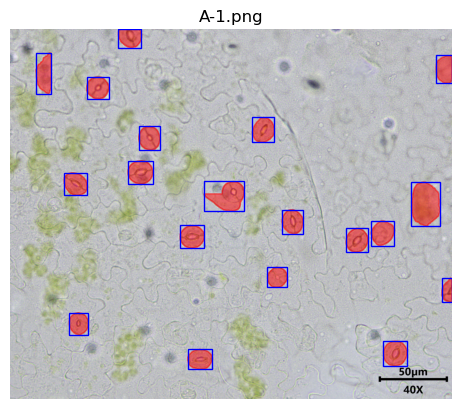

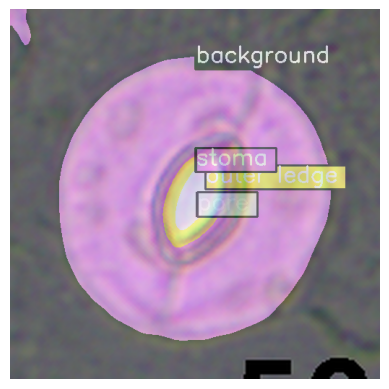

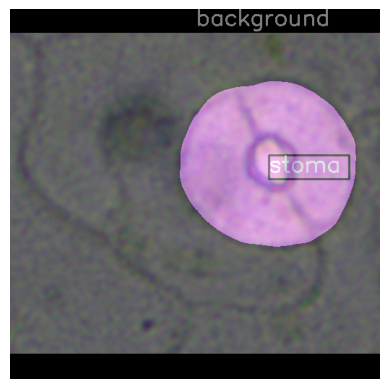

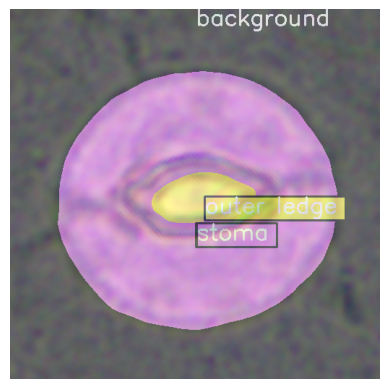

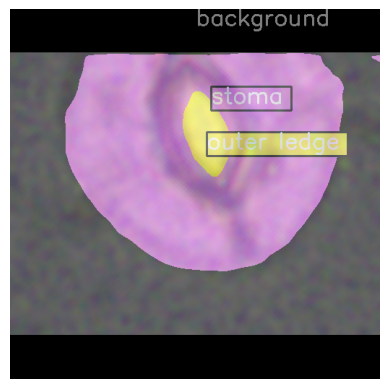

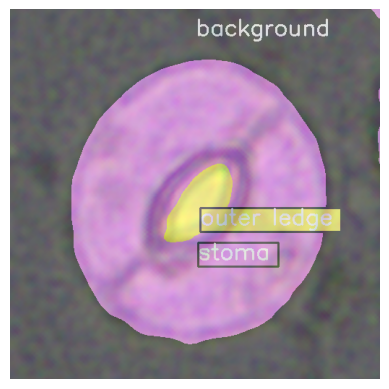

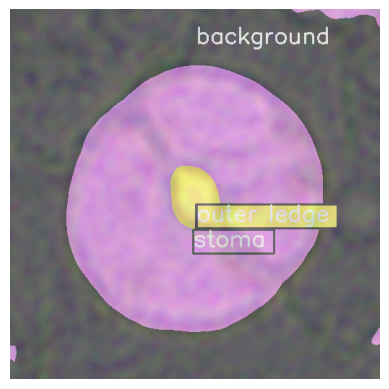

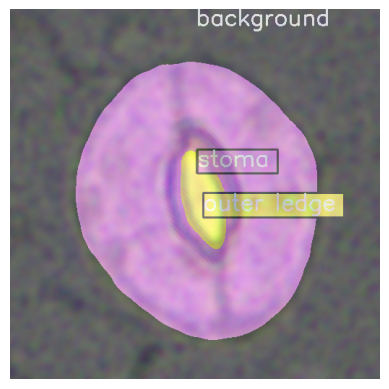

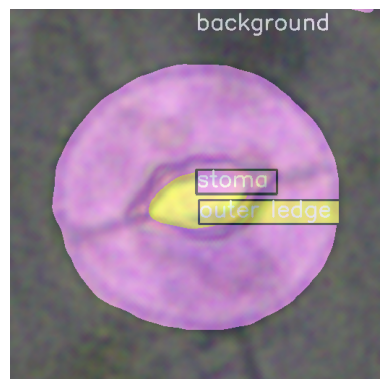

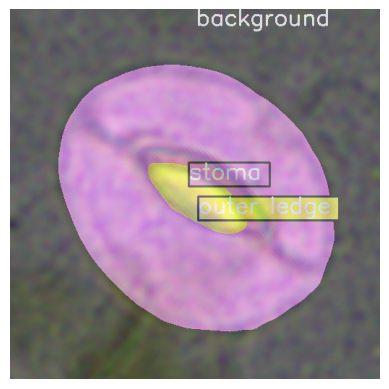

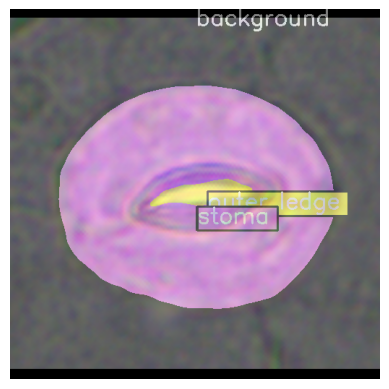

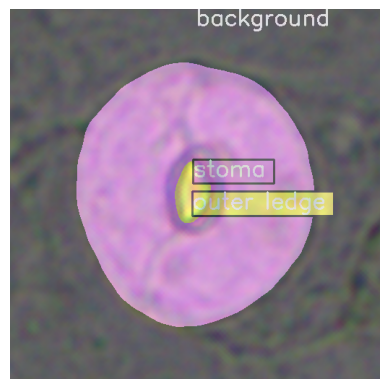

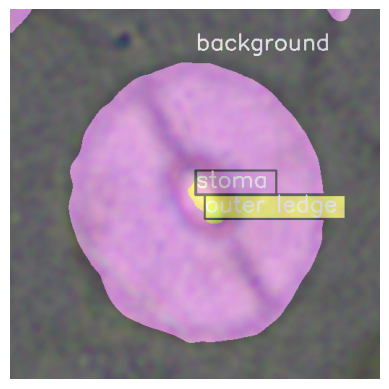

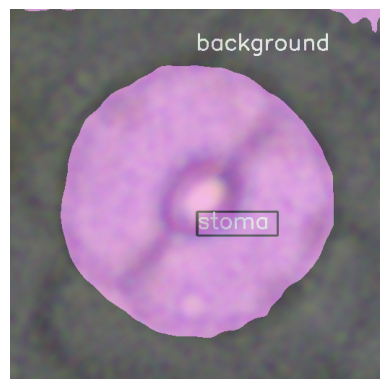

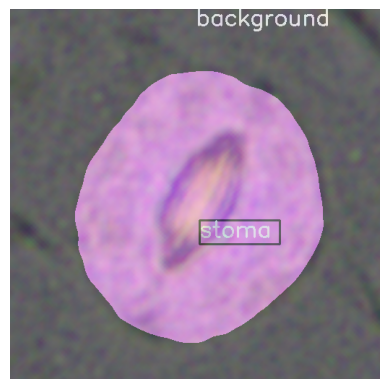

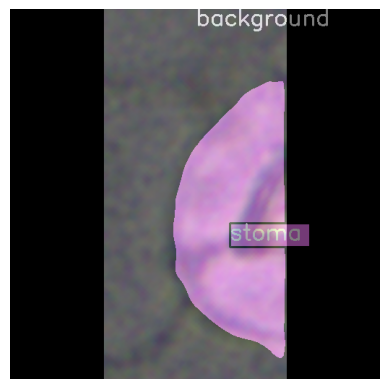

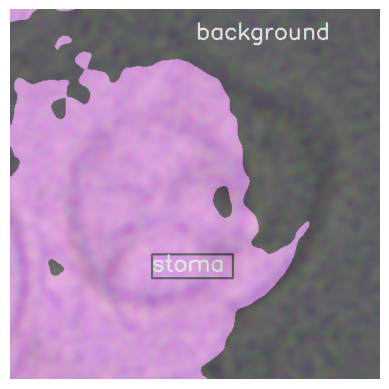

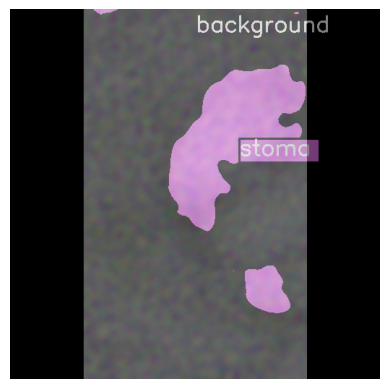

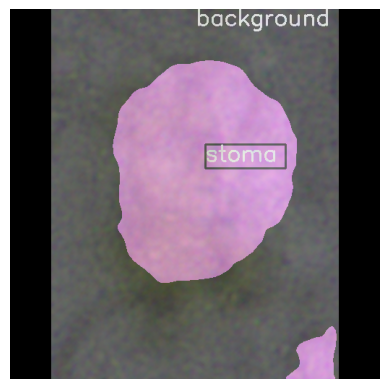

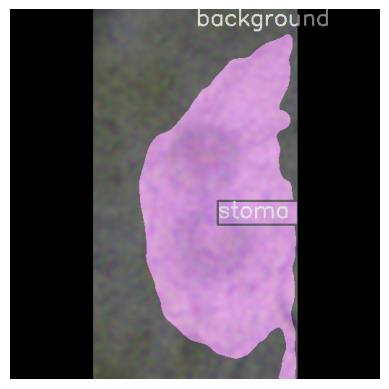

In [2]:
import os
from stomatapy.models.openmmlab import OpenMMlab
from stomatapy.core.core import get_paths


# input_dir = 'Datasets/Casado-Garcia2020/Processed/G. max'
input_dir = 'Datasets/test'
image_paths = get_paths(input_dir, file_extension='.png')[:1]

test = OpenMMlab(
        detector_config_path='Checkpoints/Swin-S_Mask2Former_2906_SanteliaPeels/Swin-s_mask2former_config.py',
        detector_weight_path='Checkpoints/Swin-S_Mask2Former_2906_SanteliaPeels/best_coco_segm_mAP_epoch_220.pth',
        detector_threshold=0.8,
        segmentor_config_path='Checkpoints/Rein_Dinov2_Mask2Former_2906_SanteliaPeels/rein_dinov2_mask2former_config.py',
        segmentor_weight_path='Checkpoints/Rein_Dinov2_Mask2Former_2906_SanteliaPeels/dinov2_segmentor.pth',
        use_sahi=True
        ).segment_cell(image_paths, if_resize_image=True, if_visualize=True, if_auto_label=False)
#     tests.append(test)

In [1]:
%cd ..

c:\Users\zhongyua\OneDrive\Academics\2023 ETH\Projects\PhD thesis\StomataPy


In [9]:
import os
from stomatapy.models.openmmlab import OpenMMlab
from stomatapy.core.core import get_paths


input_dir = 'Datasets/Sun2021/Processed/T. aestivum/Unlabeled'

image_paths = get_paths(input_dir, '.png') + get_paths(input_dir, '.tif') + get_paths(input_dir, '.jpg')

test = OpenMMlab(
        detector_config_path='Checkpoints/Swin-S_Mask2Former_temp_0822/Swin-s_mask2former_config.py',
        detector_weight_path='Checkpoints/Swin-S_Mask2Former_temp_0822/best_coco_segm_mAP_epoch_295.pth',
        detector_threshold=0.8,
        segmentor_config_path='Checkpoints/Rein_Dinov2_Mask2Former_gmax/rein_dinov2_mask2former_config.py',
        segmentor_weight_path='Checkpoints/Rein_Dinov2_Mask2Former_gmax/dinov2_segmentor.pth',
        use_sahi=True
    ).detect_stomata(image_paths, if_resize_image=True, if_visualize=False, if_auto_label=True)

Loads checkpoint by local backend from path: Checkpoints/Swin-S_Mask2Former_temp_0822/best_coco_segm_mAP_epoch_295.pth


100%|██████████| 68/68 [07:39<00:00,  6.75s/it]


Converting predictions to ISAT JSON files...


100%|██████████| 68/68 [00:21<00:00,  3.23it/s]


In [1]:
%cd ..

c:\Users\zhongyua\OneDrive\Academics\2023 ETH\Projects\PhD thesis\StomataPy


In [4]:
import os
from stomatapy.models.openmmlab import OpenMMlab
from stomatapy.core.core import get_paths


input_dir = 'Datasets/Casado-Garcia2020/Processed/P. vulgaris/Unlabeled - Copy'
image_paths = get_paths(input_dir, file_extension='.jpg')

test = OpenMMlab(
    detector_config_path='Checkpoints/Swin-S_Mask2Former_pvulgaris/Swin-s_mask2former_config.py',
    detector_weight_path='Checkpoints/Swin-S_Mask2Former_pvulgaris/best_coco_segm_mAP_epoch_145.pth',
    detector_threshold=0.2,
    sahi_overlap_ratio=0.2,
    use_sahi=True
    ).detect_objects(image_paths=image_paths, if_resize_image=True, if_auto_label=True)

Loads checkpoint by local backend from path: Checkpoints/Swin-S_Mask2Former_pvulgaris/best_coco_segm_mAP_epoch_145.pth


100%|██████████| 164/164 [20:10<00:00,  7.38s/it]


## inference

In [1]:
from stomata_py.inference_api.stomata_inference import StomataSeeker
StomataSeeker(input_dir='Data//Trial 2',
              output_name='Results aperture',
              batch_size=20,
              concatenate_excels=True,
              ensemble_detectors=False,
              object_detector_config_path='Applications/Configs/OBJECT_Stomata_dino_swin-l.py',
              object_detector_weight_path='Applications/Weights/OBJECT_Stomata_dino_swin-l_2023August13.pth',
              object_detector_threshold=0.2,
              instance_detector_config_path='Applications/Configs/INSTANCE_Stomata_mask2former_swin-s.py',
              instance_detector_weight_path='Applications/Weights/INSTANCE_Stomata_mask2former_swin-s_2023August13.pth',
              instance_detector_threshold=0.6,
              segmentor_config_path='Applications/Configs/SEGMENTATION_Stomata_mask2former_swin-I.py',
              segmentor_weight_path='Applications/Weights/SEGMENTATION_Stomata_mask2former_swin-I_2023August15.pth').batch_predict()


      _____ ____ ____  ______   ___ _     ____  ____      _      ____ ____  
     / ___//    |    \|      | /  _| |   |    |/    |    | |    /    |    \ 
    (   \_|  o  |  _  |      |/  [_| |    |  ||  o  |    | |   |  o  |  o  )
     \__  |     |  |  |_|  |_|    _| |___ |  ||     |    | |___|     |     |
     /  \ |  _  |  |  | |  | |   [_|     ||  ||  _  |    |     |  _  |  O  |
     \    |  |  |  |  | |  | |     |     ||  ||  |  |    |     |  |  |     |
      \___|__|__|__|__| |__| |_____|_____|____|__|__|    |_____|__|__|_____|
    

  Done! 

 processed 0 images in 0.0 min
 detected 0 stomata and measured 0 stomata

 
  there is no image provided any use in this run; please check the following possibilities:

 1. check if your input directory is correct

 2. maybe you forgot to put the "scale.txt" file in your folder?

 3. is the image quality good enough?

 4. are image formats not supported? currently the program supports 
 ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp', '.

## inference stomata annotations

In [ ]:
import copy
from stomata_py.core.core import *
from stomata_py.core.stomata_traits import best_distance
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

def get_aperture(seg_mask):
    a_pore = len(np.where(np.all(seg_mask == Stomata_Colors[3].mask_rgb, axis=-1))[0])  # pore area
    a_outer_ledge = len(np.where(np.all(seg_mask == Stomata_Colors[2].mask_rgb, axis=-1))[0]) + a_pore  # outer ledge area
    a_stomata = len(np.where(np.all(seg_mask == Stomata_Colors[1].mask_rgb, axis=-1))[0]) + a_outer_ledge  # stomata area
    stomata_pixel_ratio = a_stomata / seg_mask.shape[0] / seg_mask.shape[1] * 100  # as a quality check metric
    a_pore_absolute = a_pore * (1 / 8.0) ** 2  # pore area in square micrometer
    a_outer_ledge_absolute = a_outer_ledge * (1 / 8.0) ** 2  # outer ledge area in square micrometer
    a_stomata_absolute = a_stomata * (1 / 8.0) ** 2  # stomata area in square micrometer
    return [a_pore_absolute, a_outer_ledge_absolute, a_stomata_absolute, stomata_pixel_ratio]

def text4name(patch_stitched, patch_name):
    text_image = np.zeros((80, patch_stitched.shape[1], 3), np.uint8)  # create a black image with the same width as the concatenated image for writing text
    font_scale, font_color, line_type, font = 0.6, (255, 255, 255), 2, cv2.FONT_HERSHEY_SIMPLEX  # noqa: define the font and line type
    (text_width, text_height) = cv2.getTextSize(patch_name, font, font_scale, line_type)[0]
    text_x = (text_image.shape[1] - text_width) // 2  # text x coordinate
    text_y = (text_image.shape[0] + text_height) // 2  # text y coordinate
    cv2.putText(text_image, patch_name, (text_x, text_y), font, font_scale, font_color, line_type)  # write the text to the image
    return cv2.vconcat([text_image, patch_stitched])


batch_results = pd.DataFrame(columns=['image name', 'image height', 'image width', 'scale (pixels/\u03BCm)', 'stomata lenghth (\u03BCm)', 'stomata width (\u03BCm)',
                                    'outer_ledge lenghth (\u03BCm)', 'outer_ledge width (\u03BCm)', 'stomata area (\u03BCm\N{SUPERSCRIPT TWO})', 'outer ledge area (\u03BCm\N{SUPERSCRIPT TWO})',
                                    'pore area (\u03BCm\N{SUPERSCRIPT TWO})', 'openness (%)'])

images_dir = 'Data//Training//Stomata//Peels//Stomata_mmseg//images'
masks_dir = 'Data//Training//Stomata//Peels//Stomata_mmseg//labels'
output_dir = 'Data//Training//Stomata//Peels//Stomata_mmseg//results'
os.makedirs(output_dir, exist_ok=True)

image_names = sorted(os.listdir(images_dir), key=str.casefold)
image_names = [name for name in image_names if any(name.lower().endswith(file_type) for file_type in image_types)]
image_paths = [os.path.join(images_dir, name) for name in image_names]
mask_paths = [os.path.join(masks_dir, name) for name in image_names]


for idx, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):

    image = imread_rgb(image_paths[idx])
    seg_mask = imread_rgb(mask_paths[idx])

    refined_seg_mask = np.zeros((*seg_mask.shape[:2], 3), dtype=np.uint8)  # create a black image
    stomata_region = binary(color_select(seg_mask, seg_mask, Stomata_Colors[1].mask_rgb))
    ol_region = binary(color_select(seg_mask, seg_mask, Stomata_Colors[2].mask_rgb))
    pore_region = binary(color_select(seg_mask, seg_mask, Stomata_Colors[3].mask_rgb))
    refined_seg_mask[pore_region == 255] = Stomata_Colors[1].mask_rgb
    refined_seg_mask[ol_region == 255] = Stomata_Colors[1].mask_rgb  
    refined_seg_mask[stomata_region == 255] = Stomata_Colors[1].mask_rgb 

    stomata_contour, _ = cv2.findContours(binary(refined_seg_mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

    refined_seg_mask = np.zeros((*seg_mask.shape[:2], 3), dtype=np.uint8)  # create a black image
    stomata_region = binary(color_select(seg_mask, seg_mask, Stomata_Colors[1].mask_rgb))
    ol_region = binary(color_select(seg_mask, seg_mask, Stomata_Colors[2].mask_rgb))
    pore_region = binary(color_select(seg_mask, seg_mask, Stomata_Colors[3].mask_rgb))
    refined_seg_mask[pore_region == 255] = Stomata_Colors[1].mask_rgb
    refined_seg_mask[ol_region == 255] = Stomata_Colors[1].mask_rgb  

    ol_contour, _ = cv2.findContours(binary(refined_seg_mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

    ol_contour_mask = np.zeros((*seg_mask.shape[:2], 3), dtype=np.uint8)  # create a black image
    cv2.drawContours(ol_contour_mask, ol_contour, -1, (255, 255, 255), 1)  # draw the outer ledge contour
    stomata_contour_mask = copy.deepcopy(ol_contour_mask)  # make a copy of the outer ledge contour
    cv2.drawContours(stomata_contour_mask, stomata_contour, -1, (255, 255, 255), 1)  # draw the stomata contour
    cv2.imwrite(os.path.join(output_dir, image_names[idx]), cv2.cvtColor(stomata_contour_mask, cv2.COLOR_RGB2BGR))
    
    stomata_lenghth_pixel, stomata_width_pixel, stomata_trait = best_distance(stomata_contour_mask)
    ol_lenghth_pixel, ol_width_pixel, ol_trait = best_distance(ol_contour_mask)
    stomata_lenghth, stomata_width = stomata_lenghth_pixel * (1 / 8.0), stomata_width_pixel * (1 / 8.0) 
    ol_lenghth, ol_width = ol_lenghth_pixel * (1 / 8.0), ol_width_pixel * (1 / 8.0)
    patch_stitched = np.hstack((image , seg_mask, stomata_trait, ol_trait))
    patch_stitched = text4name(patch_stitched, image_names[idx])
    #cv2.imwrite(os.path.join(output_dir, image_names[idx]), cv2.cvtColor(patch_stitched, cv2.COLOR_RGB2BGR)) 
    
    a_pore_absolute, a_ol_absolute, a_stomata_absolute, stomata_pixel_ratio = get_aperture(seg_mask)

    result = {'image name': [image_names[idx]],
            'image height': [image.shape[0]],
            'image width': [image.shape[1]],
            'scale (pixels/\u03BCm)': [8.0],
            'stomata lenghth (\u03BCm)': [stomata_lenghth],
            'stomata width (\u03BCm)': [stomata_width],
            'outer ledge lenghth (\u03BCm)': [ol_lenghth],
            'outer ledge width (\u03BCm)': [ol_width],
            'stomata area (\u03BCm\N{SUPERSCRIPT TWO})': [a_stomata_absolute],
            'outer ledge area (\u03BCm\N{SUPERSCRIPT TWO})': [a_ol_absolute],
            'pore area (\u03BCm\N{SUPERSCRIPT TWO})': [a_pore_absolute],
            'openness (%)': [a_ol_absolute / a_stomata_absolute * 100]}
    result = pd.DataFrame(data=result)
    batch_results = pd.concat([batch_results, result], axis=0) 
batch_results.to_excel(os.path.join(output_dir, 'stomata aperture.xlsx'), index=False)
 

In [ ]:
import os
from tqdm import tqdm
from stomata_py.core.core import imread_rgb
from stomata_py.core.stomata_traits_2 import GetDiameter

input_dir = 'Data//Training//Stomata//Peels//Stomata_mmseg//results2'
file_names = os.listdir(input_dir)
file_paths = [os.path.join(input_dir, file_name) for file_name in file_names]
masks = [imread_rgb(file_path) for file_path in file_paths]

for mask in tqdm(masks, total=len(masks)):
    stomata_lenghth, stomata_width, angle = GetDiameter(mask, shrink_ratio=1.2, line_thickness=3).pca(show_result=True)


## inference starch

In [ ]:
from stomata_py.inference_api.starch_inference import StarchSeeker

StarchSeeker(input_dir='Data//Testing//Starch//Kidney//Lucia ERC 04_2021 N. exaltata Blue Light',
            output_name='Results starch',
            batch_size=40,
            detector_config_path='Applications//Configs//INSTANCE_mask2former_swin-s.py',
            detector_weight_path='Applications//Weights//INSTANCE_BOTH_mask2former_swin-s_2023.05.26.pth',
            detector_threshold=0.9,
            segmentor_config_path='Applications//Configs//SEMANTIC_mask2former_swin-I.py',
            segmentor_weight_path='Applications//Weights//SEMANTIC_BOTH_mask2former_swin-I_2023.05.27.pth',
            concatenate_excels=True).bacth_predict()